In [1]:
from chickpea.cma import CavityModeAnalysis
import legume
import numpy as np
import time

%load_ext memory_profiler

We setup the crystal cavity we are interested in simulating.

In [2]:
# Number of PhC periods in x and y directions
Nx, Ny = 12, 12


# Regular PhC parameters
a=1.0

dslab = 0.26/0.366
n_slab = 3.4
ra = 0.344


# Initialize a lattice and PhC
lattice = legume.Lattice([Nx*a, 0], [0, Ny*np.sqrt(3)/2*a])

# Make x and y positions in one quadrant of the supercell
# We only initialize one quadrant because we want to shift the holes symmetrically
xp, yp = [], []
nx, ny = Nx, Ny
for iy in range(ny):
    for ix in range(nx):
        if iy == 0 and ix in (-1 %nx,0,1):
            continue
        if iy in (1,-1 % ny) and ix in (0, -1 % nx):
            continue
        xp.append((ix + (iy%2)*0.5)*a)
        yp.append((iy*np.sqrt(3)/2)*a)

nc = len(xp)


we define some meta properties of the crystal.

In [3]:
super_periods = np.array((Nx*a, 2*Ny*np.sqrt(3)/2*a))
defect_margins = np.array([0.25,0.25])

# Define L3 PhC cavity with shifted holes
def cavity():
    # Initialize PhC
    phc = legume.PhotCryst(lattice)

    # Add a layer to the PhC
    phc.add_layer(d=dslab, eps_b=n_slab**2)

    # Apply holes symmetrically in the four quadrants
    for ic, x in enumerate(xp):
        yc = yp[ic]
        xc = xp[ic]

        phc.add_shape(legume.Circle(x_cent=xc, y_cent=yc, r=ra))
    return phc

phc = cavity()

Next, we construct the base lattice, the photonic crystal object, and the GME object:

In [4]:
a1 = np.array([a*0.5, a*np.sqrt(3)/2])
a2 = np.array([a*0.5, -a*np.sqrt(3)/2])

base_lattice = legume.Lattice(a1,a2)
base_phc = legume.PhotCryst(base_lattice)
base_phc.add_layer(d=dslab, eps_b=n_slab**2)
base_phc.layers[0].add_shape(legume.Circle(eps=1.0, r=ra))


We construct the cavity mode analysis object

In [5]:
cma = CavityModeAnalysis(phc, base_phc, super_periods, defect_margins, layer=0, gmax=3, base_gmax=3)

First lets find the band-gaps of the base crystal. This will give us an idea of where the cavity modes should be.

In [1]:
band_gaps, k_air, k_eps =cma.find_band_gaps(band_tol=0.1, order=np.array([0,3]), lc_trim=0.025, numeig=20)

gmg_ratio = np.array([(band_gap[1] - band_gap[0]) / band_gap[2] for band_gap in band_gaps])

legume.viz.bands(cma.base_gme,  trim_light_cone=True, lc_trim=0.025)

# With forethought we know there is only one band-gap for this crystal.
print("Band gap lower bound: %f.\n"
      "Band gap upper bound: %f.\n"
      "Band gap center: %f.\n"
      "Gap-midgap ratio: %f.\n"
      "The top of the air band is at k= (%f, %f).\n"
      "The bottom of the dielectric band is at k= (%f, %f).\n" %  (band_gaps[0][0], band_gaps[0][1], band_gaps[0][2],
                                                                   gmg_ratio[0], k_air[0], k_air[1], k_eps[0], k_eps[1]))

NameError: name 'cma' is not defined

From this data we can deduce that we should be looking for cavity modes in the region
$0.25 \frac{\omega a}{2\pi c}-0.38\frac{\omega a}{2\pi c}$. In an optimization, we may want to use data like this
to tune the properties of the base crystal.

Now that we have the frequency region we are interested in we can setup the simulation on the super crystal.



In [7]:

options = {'verbose': True,
           'gmode_inds': [0], # This is a TE band gap and we assume that there are no higher order modes.
           'gradients': 'approx', # We don't need exact gradients at this time.
           'numeig': 100, # We happen to know this is a good number to fill the band gap.
                         # Run with higher value until you save modes outside of the band gap.
           'eig_solver': 'eigh',
           'eig_sigma': band_gaps[0][2], # We target the center of the band gap
           'compute_im': False # We only want to calculate the loss rates for cavity modes.
           }

# We simulate on a k-point away from the light cone and one closer to the center.
# Naturally we will only see cavity modes with fourier components at this point. For a full analysis
# it may be prudent to search in multiple places.
kpoints = cma.gme.phc.lattice.bz_path([[k_air[0][0], k_air[1][0]], [k_air[0][0]/2,k_air[1][0]/2]], [1])['kpoints']

In [8]:
%memit cma.gme.run(kpoints=kpoints, **options)

279.9845s total time for real part of frequencies, of which
  0.8320s for guided modes computation using the gmode_compute='exact' method
  3.2060s for inverse matrix of Fourier-space permittivity
  242.7740s for matrix diagionalization using the 'eigh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes
peak memory: 4468.05 MiB, increment: 4357.21 MiB


Because we simulated outside the light cone we can filter cavity modes by
restricting the frequency range to the band gap and filtering off high mode volume modes.

In [9]:
arg_list, v = cma.mode_volume_filter(max_volume=5, band_filter=True)

In [10]:
q=[]
freqs_im=[]
rad_coup=[]
rad_gvec=[]
for kind, mlist in enumerate(arg_list):
    freqs_im_list, rad_coup_list, rad_gvec_list = cma.gme.compute_rad(kind=kind, minds=mlist)
    qlist = cma.gme.freqs[kind][mlist]/(2*freqs_im_list)
    q.append(qlist)
    freqs_im.append(freqs_im_list)
    rad_coup.append(rad_coup_list)
    rad_gvec.append(rad_gvec_list)

Finally, knowing the mode volume and the Q factor of our we plot the magnitude of the electric fields

C:\Users\stephen\PycharmProjects\legume\legume\viz.py:773: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f1, axs = plt.subplots(1, sp, constrained_layout=True)


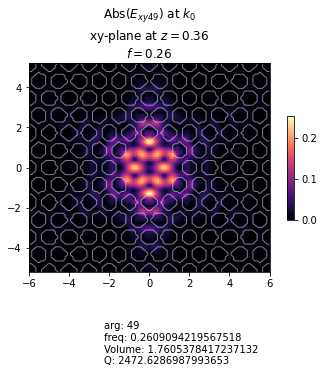

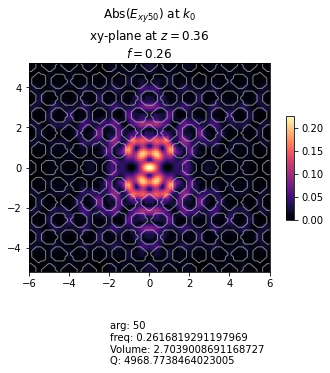

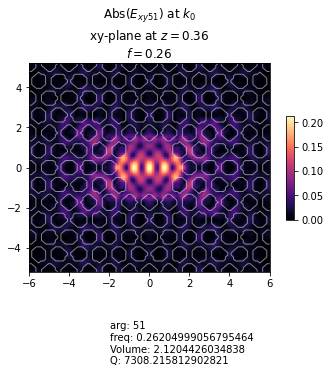

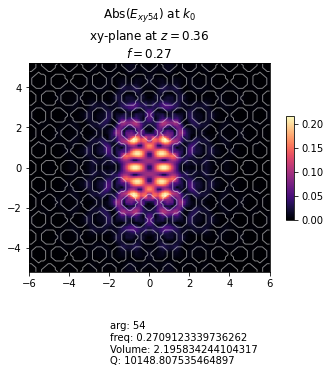

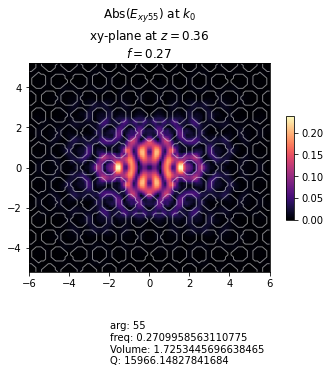

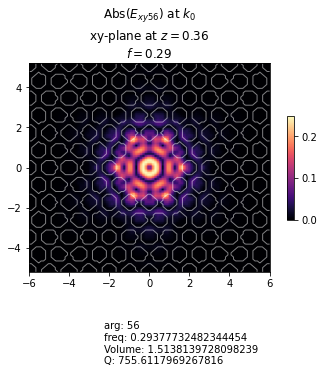

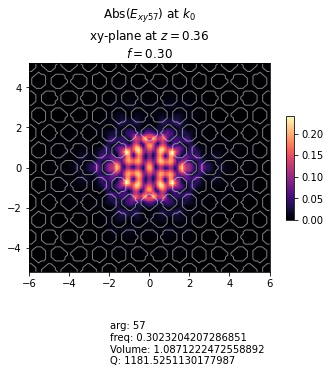

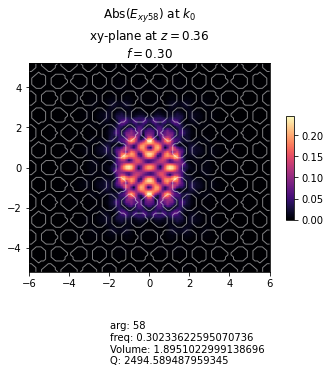

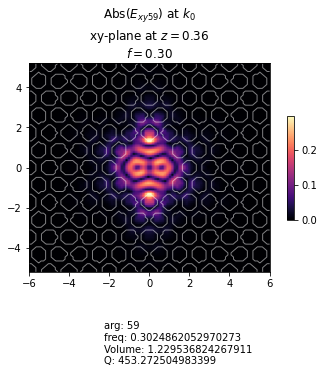

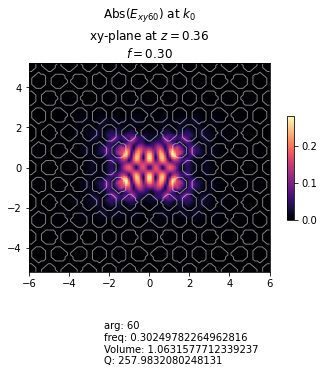

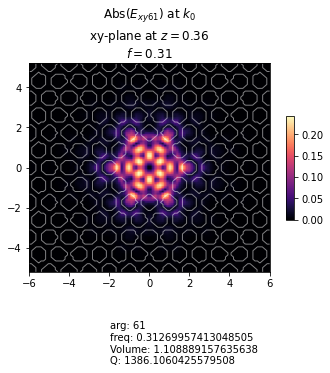

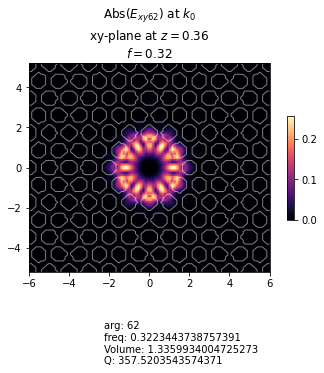

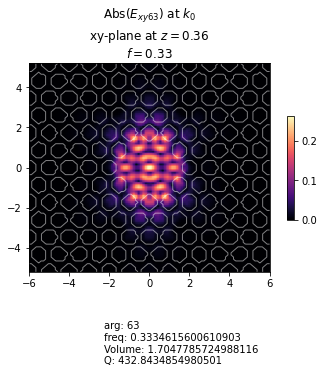

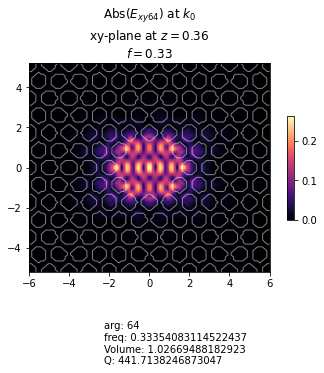

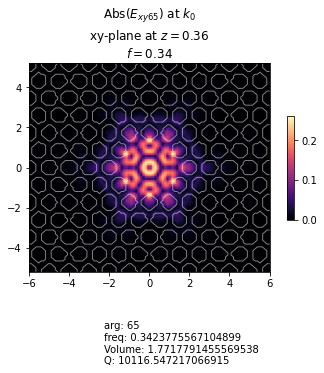

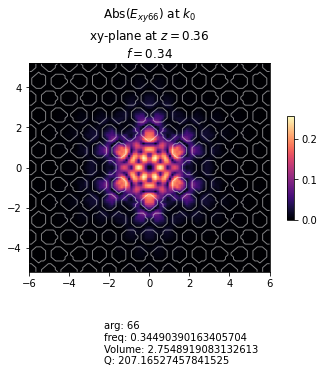

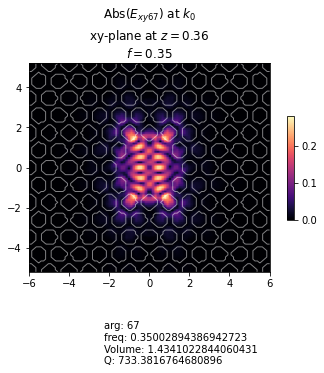

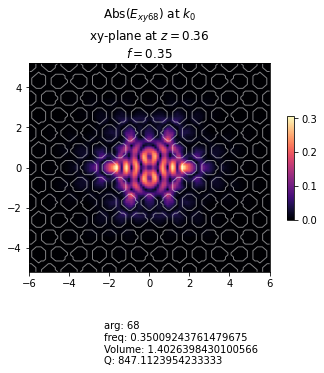

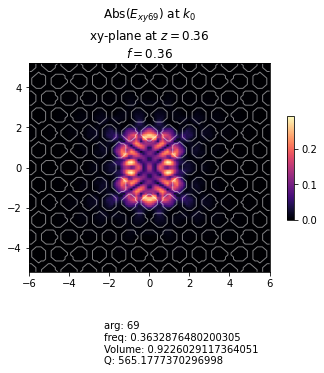

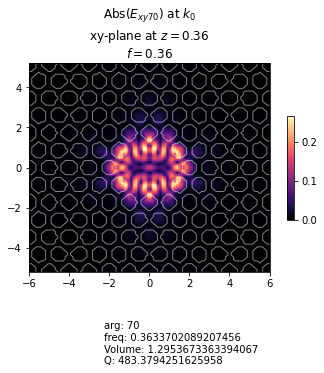

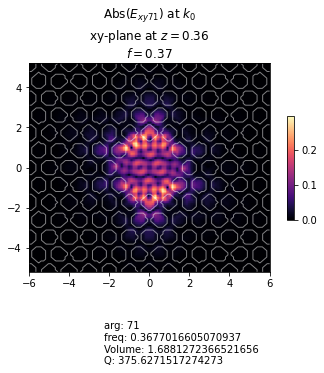

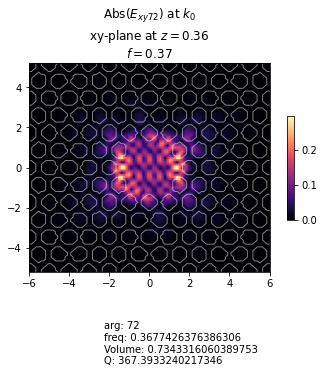

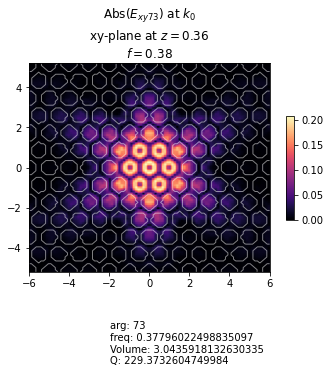

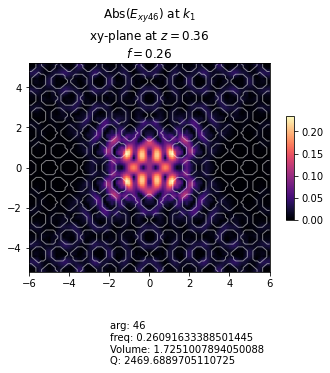

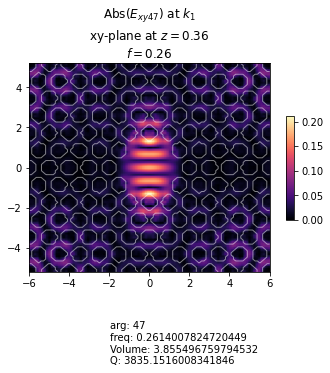

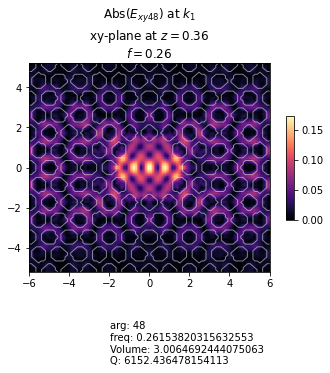

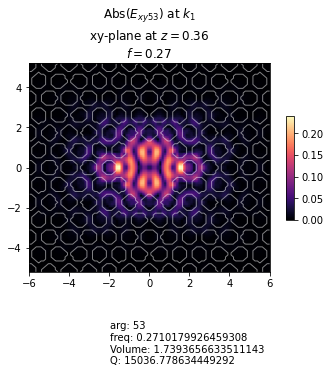

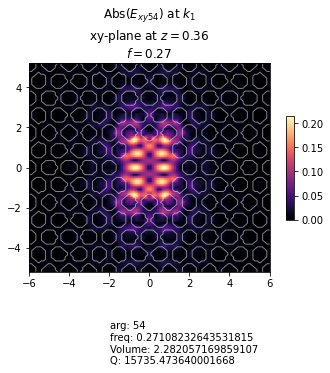

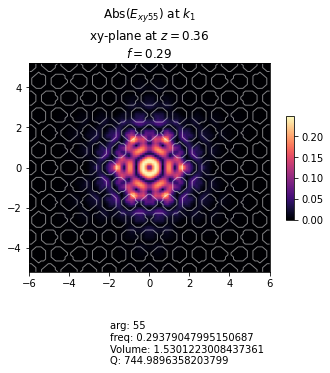

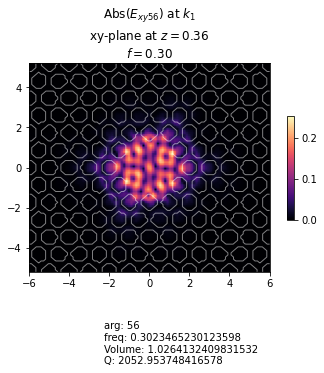

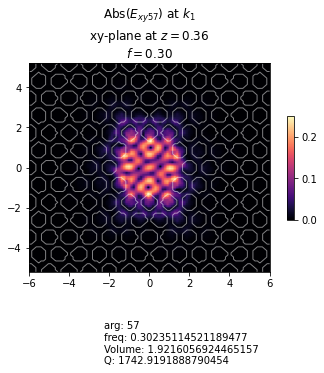

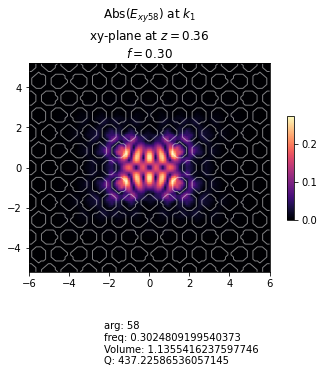

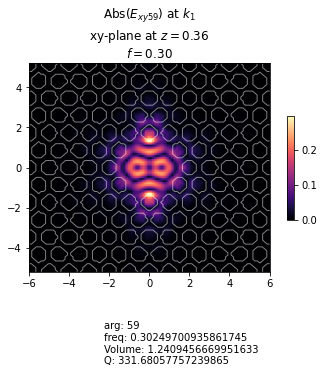

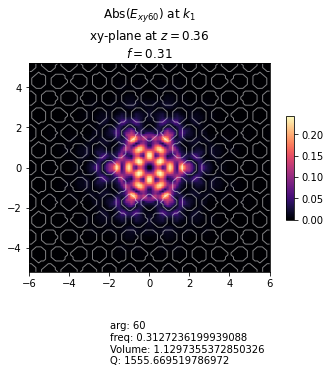

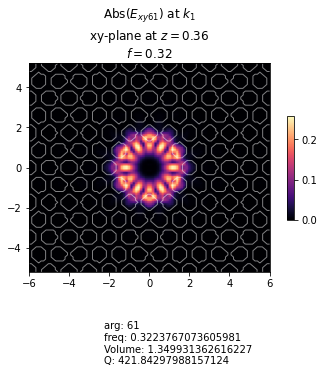

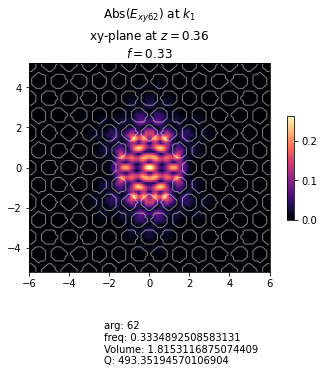

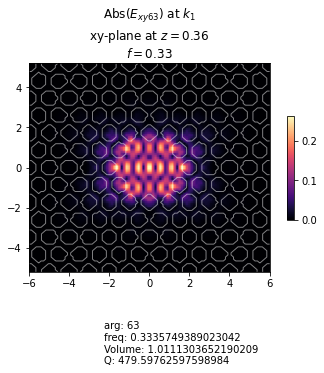

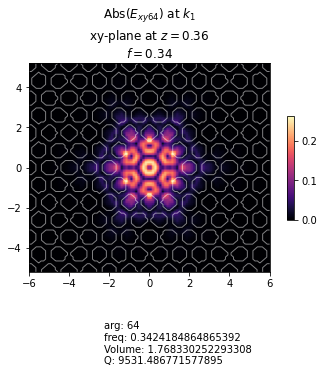

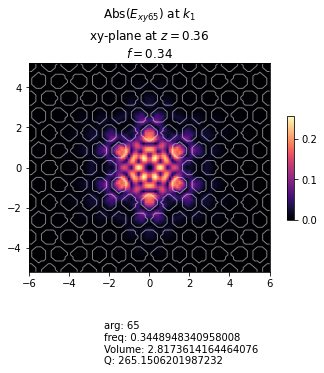

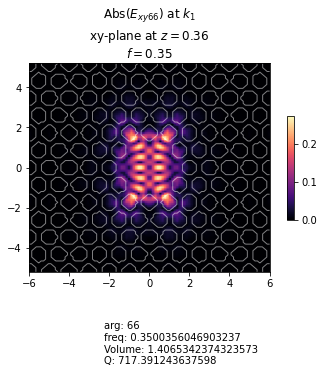

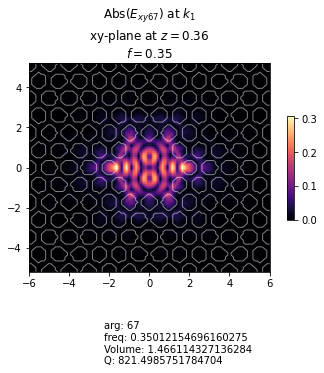

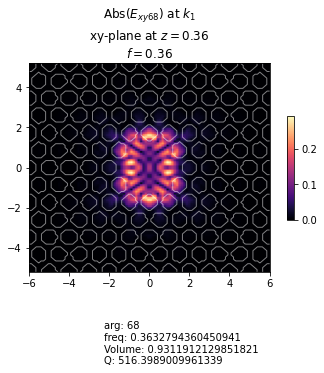

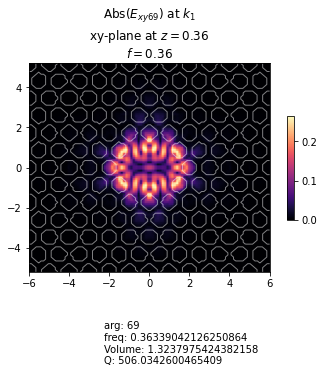

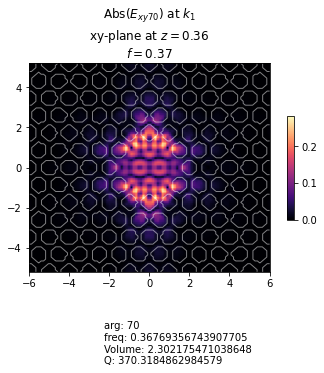

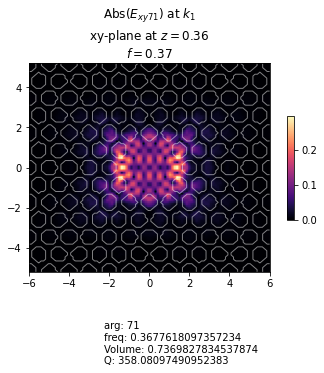

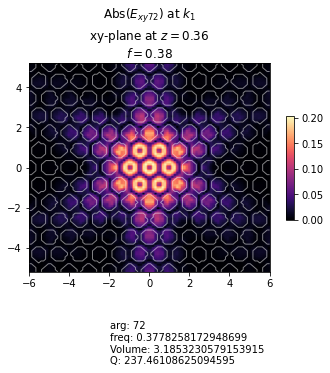

In [11]:
for kind, mlist in enumerate(arg_list):
    for i, mind in enumerate(mlist):
        fig=legume.viz.field(cma.gme,'E', kind, mind, z=dslab/2, component='xy', val='abs', N1=100, N2=100, norm=True)
        fig.text(0.5,-0.25,
                 "arg: " + str(mind)+ "\n"
                 + "freq: " + str(cma.gme.freqs[kind][mind]) + "\n"
                 + "Volume: " + str(v[kind][i]) + "\n"
                 + "Q: " + str(q[kind][i]))

We note that the same modes at different k-values have different Q factors. For instance mode 53 and 54.

We can target these modes by using the eish solver. This solver solves for only a couple of eigenmodes at a time,
although takes longer for all the modes.

Let is create a new cma object with a higher gmax and run the simulation focusing on those modes using the eish solver.

In [13]:
cma_b = CavityModeAnalysis(phc, base_phc, super_periods, defect_margins, layer=0, gmax=4, base_gmax=3)

options = {'verbose': True,
           'gmode_inds': [0], # This is a TE band gap and we assume that there are no higher order modes.
           'gradients': 'approx', # We don't need exact gradients at this time.
           'eig_sigma': 0.3424,
           'numeig': 1, # Lets target the two modes around 0.271 frequency
           'eig_solver': 'eigsh',
           'compute_im': True # We know which modes we are targeting and want to calculate the loss rate.
           }

kpoints = cma_b.gme.phc.lattice.bz_path([[k_air[0][0], k_air[1][0]], [0,0]], [5])['kpoints']


%memit cma_b.gme.run(kpoints=kpoints, **options)

q_b = cma_b.gme.freqs/(2*cma_b.gme.freqs_im)

317.0806s total time for real part of frequencies, of which
  9.4667s for guided modes computation using the gmode_compute='exact' method
  10.1715s for inverse matrix of Fourier-space permittivity
  41.4758s for matrix diagionalization using the 'eigsh' solver
11.4234s for imaginary part computation
peak memory: 20404.23 MiB, increment: 12415.82 MiB


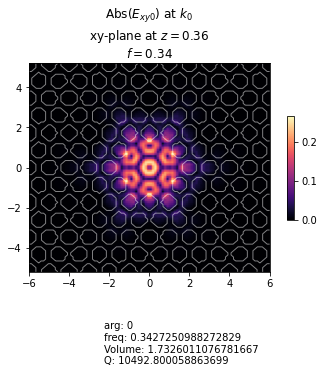

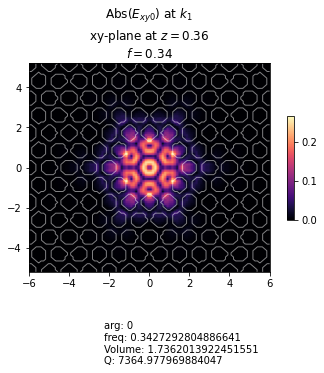

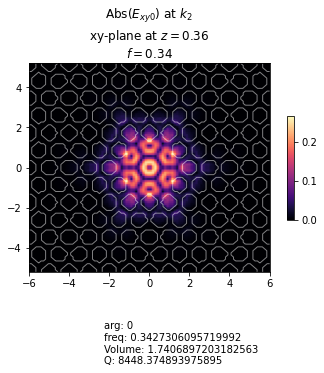

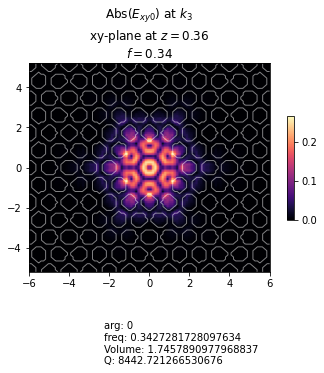

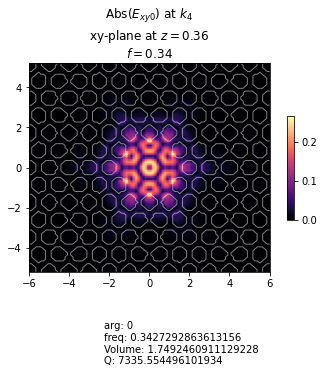

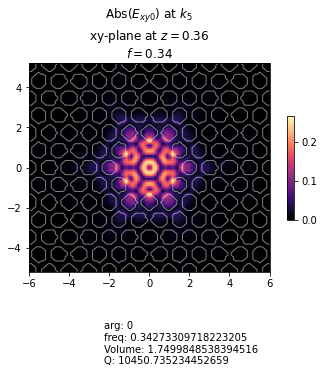

In [14]:
# Let us calculate the mode volumes again and output the results.

arg_list_b, v_b = cma_b.mode_volume_filter(max_volume=5, band_filter=False)

for kind, mlist in enumerate(arg_list_b):
    for i, mind in enumerate(mlist):
        fig=legume.viz.field(cma_b.gme,'E', kind, mind, z=dslab/2, component='xy', val='abs', N1=100, N2=100, norm=True)
        fig.text(0.5,-0.25,
                 "arg: " + str(mind)+ "\n"
                 + "freq: " + str(cma_b.gme.freqs[kind][mind]) + "\n"
                 + "Volume: " + Analyzing Photonic Crystal Cavity.ipynbstr(v_b[kind][i]) + "\n"
                 + "Q: " + str(q_b[kind][i]))

Is this a gmax convergence problem? Lets try with a higher gmax

In [15]:
cma_c = CavityModeAnalysis(phc, base_phc, super_periods, defect_margins, layer=0, gmax=5, base_gmax=3)

options = {'verbose': True,
           'gmode_inds': [0], # This is a TE band gap and we assume that there are no higher order modes.
           'gradients': 'approx', # We don't need exact gradients at this time.
           'eig_sigma': 0.3424,
           'numeig': 1, # Lets target the two modes around 0.271 frequency
           'eig_solver': 'eigsh',
           'compute_im': True # We know which modes we are targeting and want to calculate the loss rate.
           }

kpoints = cma_c.gme.phc.lattice.bz_path([[k_air[0][0], k_air[1][0]], [0,0]], [5])['kpoints']


%memit cma_c.gme.run(kpoints=kpoints, **options)

q_c = cma_c.gme.freqs/(2*cma_c.gme.freqs_im)

836.7476s total time for real part of frequencies, of which
  15.0833s for guided modes computation using the gmode_compute='exact' method
  27.4194s for inverse matrix of Fourier-space permittivity
  131.2691s for matrix diagionalization using the 'eigsh' solver
22.1688s for imaginary part computation
peak memory: 28887.75 MiB, increment: 19346.30 MiB


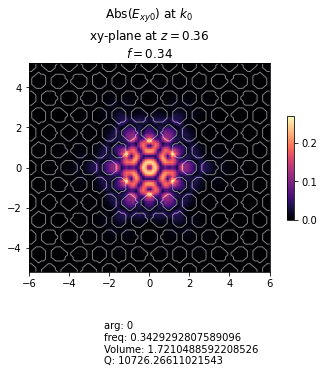

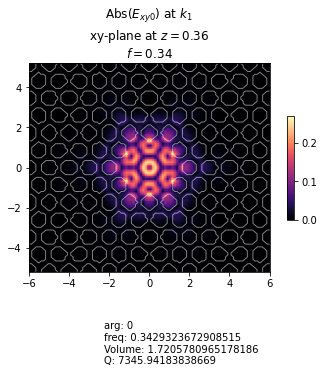

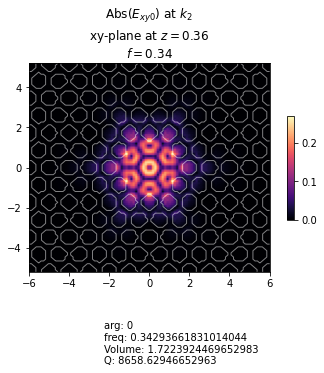

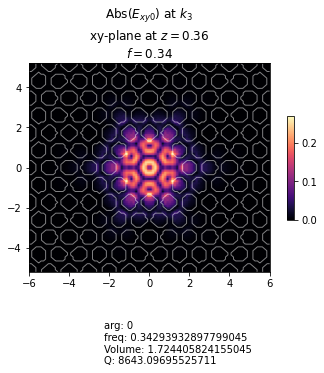

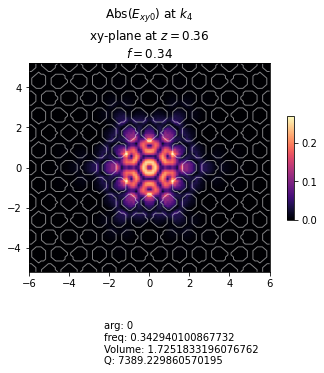

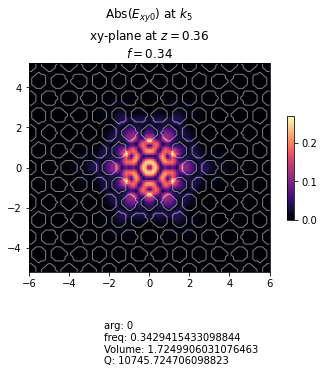

In [16]:
q_c = cma_c.gme.freqs/(2*cma_c.gme.freqs_im)

# Let us calculate the mode volumes again and output the results.

arg_list_c, v_c = cma_c.mode_volume_filter(max_volume=5, band_filter=False)

for kind, mlist in enumerate(arg_list_c):
    for i, mind in enumerate(mlist):
        fig=legume.viz.field(cma_c.gme,'E', kind, mind, z=dslab/2, component='xy', val='abs', N1=100, N2=100, norm=True)
        fig.text(0.5,-0.25,
                 "arg: " + str(mind)+ "\n"
                 + "freq: " + str(cma_c.gme.freqs[kind][mind]) + "\n"
                 + "Volume: " + str(v_c[kind][i]) + "\n"
                 + "Q: " + str(q_c[kind][i]))

C:\Users\stephen\PycharmProjects\legume\legume\viz.py:89: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  p = ax.scatter(X.flatten(), gme.freqs.flatten(),


(0.0, 0.5)

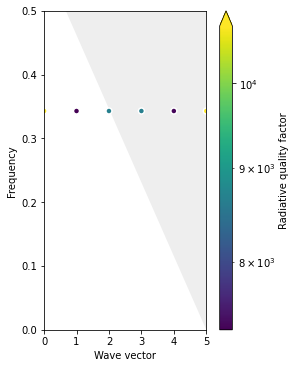

In [26]:
ax = legume.viz.bands(cma_c.gme, Q=True, )
ax.set_ylim(top=0.5)

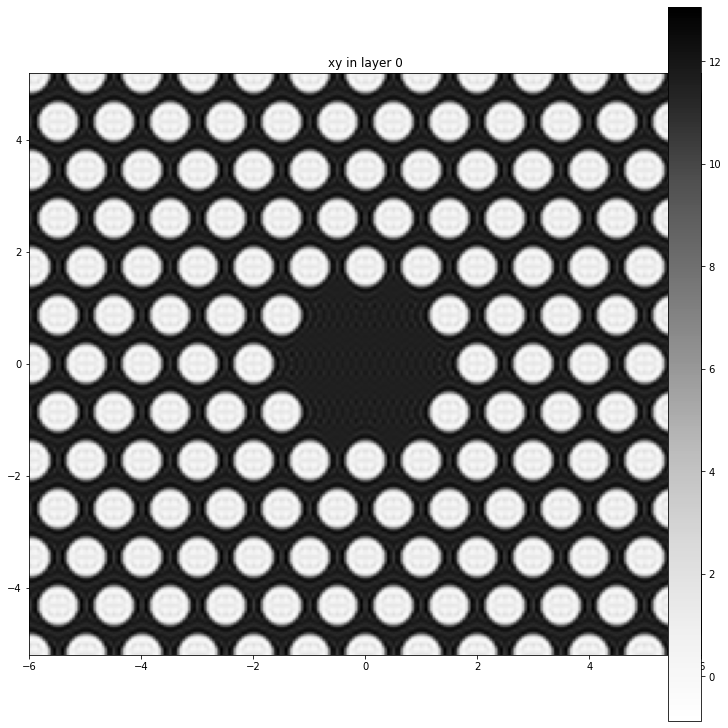

In [31]:
cma_d = CavityModeAnalysis(phc, base_phc, super_periods, defect_margins, layer=0, gmax=3, base_gmax=3)

legume.viz.eps_ft(cma_d.gme, Nx=250, Ny=250, figsize=(10,10))